# Research Component

Shor's algorithm is an important quantum algorithm for factoring integers in polynomial time, it can factor large integers exponetially faster than the best classical algorithms. And it basically uses quantum phase estimation to find the order of the integer. then based on that, it can find its factors.[<sup>1</sup>](https://quantum.cloud.ibm.com/docs/en/tutorials/shors-algorithm)

Once a sufficiently large enough quantum computer exists, Shor's algorithm can break most of the widely used asymmetric encryption algorithms like RSA, ECC and key exchange algorithms like Diffie-Hellman.   

  ## Investigate the application of shor's algorithm on RSA-2048 in comparison to a classical algorithms

As of now there are no classical algorithms that can factor all integers in polynomial time. for large integers, the best classical algorithm is General Number Field Sieve (GNFS)  which has complexity of $O(exp(c(\log N^{1/3} * \log \log N^{2/3}))$, While Shor's algorithm  complexity is of $O((\log N)^3)$[<sup>2</sup>](https://fiveable.me/quantum-computing/unit-7/shors-algorithm-implementation-complexity-analysis/study-guide/Dyt2CJCRHfQoSapP)

The largest nubmer that has been classically factored is RSA-250 which has 829 bits  on February 2020, it has been factored using GNFS, and it took 2700 CPU core-years[<sup>3</sup>](https://www.schneier.com/blog/archives/2020/04/rsa-250_factore.html). There are no exact estimate for the time needed to factor RSA-2048 using GNFS however there are some rough estimates that put it at 300 trillion years[<sup>4</sup>](https://www.quintessencelabs.com/blog/breaking-rsa-encryption-update-state-art). As for Shor's algorithms it is estimated that RSA-2048 can be broken in less than a week using 1 million noisy qubits[<sup>5</sup>](https://arxiv.org/abs/2505.15917). 

Another point to consider is the difference between key length and bit strength, RSA-2048 has a key length of 2048 bits while having a bit strength of 112 bits , So it would take $2^{112}$ guesses to break it using GNFS. Shor's algorithm reduces this further to $2^{33}$[<sup>6</sup>](https://colortokens.com/blogs/quantum-computing-cybersecurity-shors-algorithm-gnfs-rsa-encryption/).

## Shors' Algorithm for 15


Source Code from: https://quantum.cloud.ibm.com/docs/en/tutorials/shors-algorithm

- Updated code to use AerSimulator
- Removed unnecessary functions
- Added part to get both factors

In [1]:
import numpy as np
from fractions import Fraction
from math import floor, gcd, log

from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT, UnitaryGate
from qiskit.transpiler import CouplingMap, generate_preset_pass_manager
from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import SamplerV2 as Sampler

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'

In [2]:
def M2mod15():
    """
    M2 (mod 15)
    """
    b = 2
    U = QuantumCircuit(4)

    U.swap(2, 3)
    U.swap(1, 2)
    U.swap(0, 1)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

def M4mod15():
    """
    M4 (mod 15)
    """
    b = 4
    U = QuantumCircuit(4)

    U.swap(1, 3)
    U.swap(0, 2)

    U = U.to_gate()
    U.name = f"M_{b}"

    return U

In [3]:
def a2kmodN(a, k, N):
    """Compute a^{2^k} (mod N) by repeated squaring"""
    for _ in range(k):
        a = int(np.mod(a**2, N))
    return a

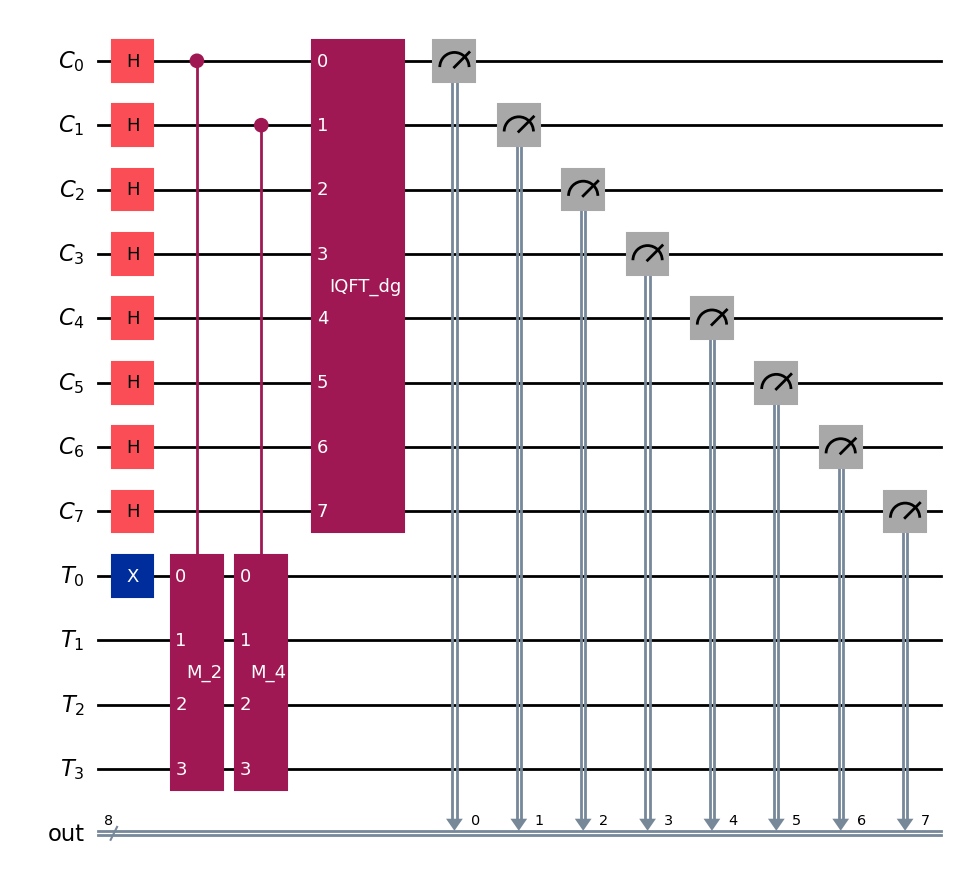

In [4]:
# Order finding problem for N = 15 with a = 2
N = 15
a = 2

# Number of qubits
num_target = floor(log(N - 1, 2)) + 1  # for modular exponentiation operators
num_control = 2 * num_target  # for enough precision of estimation

# List of M_b operators in order
k_list = range(num_control)
b_list = [a2kmodN(2, k, N) for k in k_list]

# Initialize the circuit
control = QuantumRegister(num_control, name="C")
target = QuantumRegister(num_target, name="T")
output = ClassicalRegister(num_control, name="out")
circuit = QuantumCircuit(control, target, output)

# Initialize the target register to the state |1>
circuit.x(num_control)

# Add the Hadamard gates and controlled versions of the
# multiplication gates
for k, qubit in enumerate(control):
    circuit.h(k)
    b = b_list[k]
    if b == 2:
        circuit.compose(
            M2mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    elif b == 4:
        circuit.compose(
            M4mod15().control(), qubits=[qubit] + list(target), inplace=True
        )
    else:
        continue  # M1 is the identity operator

# Apply the inverse QFT to the control register
circuit.compose(QFT(num_control, inverse=True), qubits=control, inplace=True)

# Measure the control register
circuit.measure(control, output)

circuit.draw("mpl", fold=-1)

2q-depth: 13
2q-size: 28
Operator counts: OrderedDict({'cp': 28, 'ccx': 15, 'h': 14, 'measure': 8, 'x': 1})


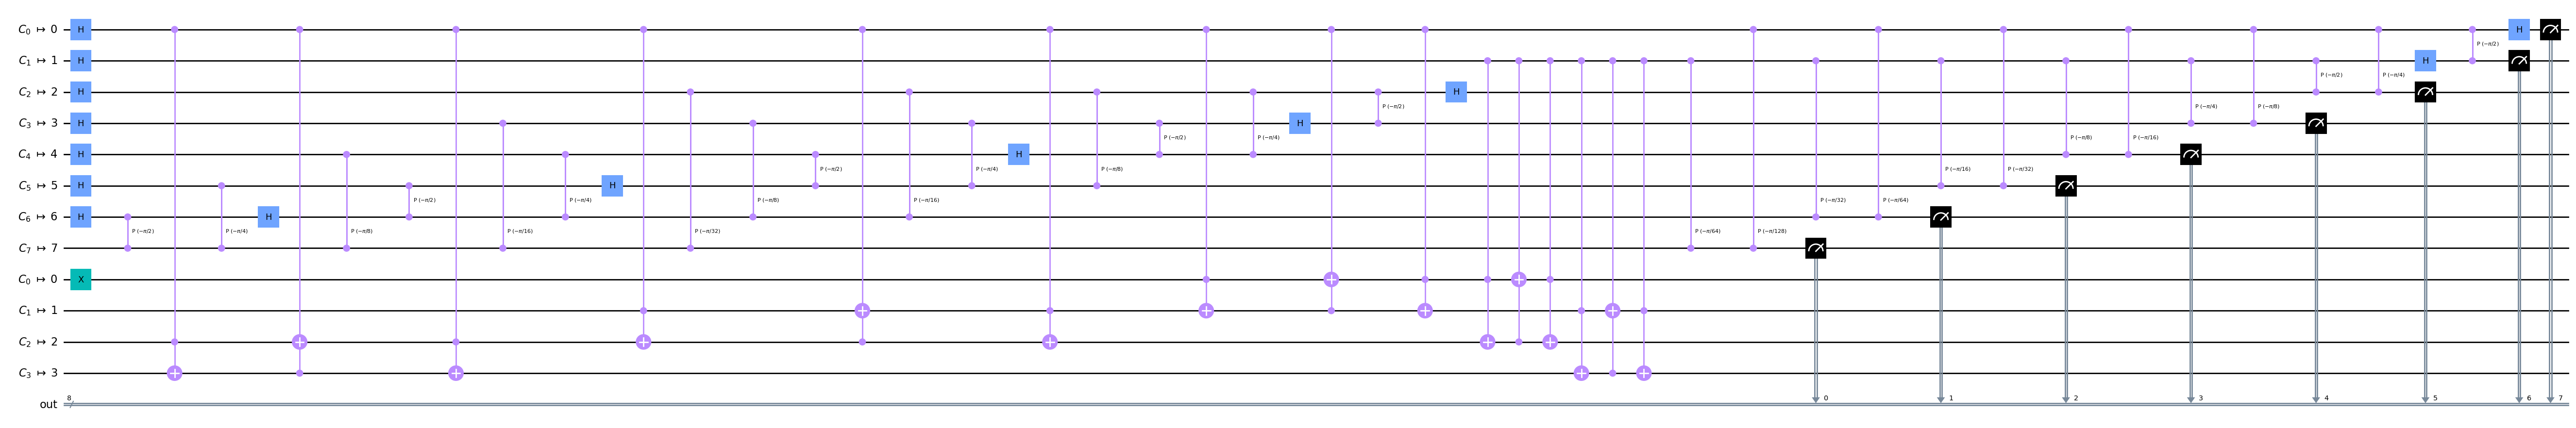

In [5]:
backend = AerSimulator()

pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

transpiled_circuit = pm.run(circuit)


print(
    f"2q-depth: {transpiled_circuit.depth(lambda x: x.operation.num_qubits==2)}"
)
print(
    f"2q-size: {transpiled_circuit.size(lambda x: x.operation.num_qubits==2)}"
)
print(f"Operator counts: {transpiled_circuit.count_ops()}")
transpiled_circuit.draw(
    output="mpl", fold=-1, style="clifford", idle_wires=False
)

In [6]:
# Sampler primitive to obtain the probability distribution
sampler = Sampler(backend)

pub = transpiled_circuit
job = sampler.run([pub], shots=1024)

In [7]:
result = job.result()[0]
counts = result.data["out"].get_counts()

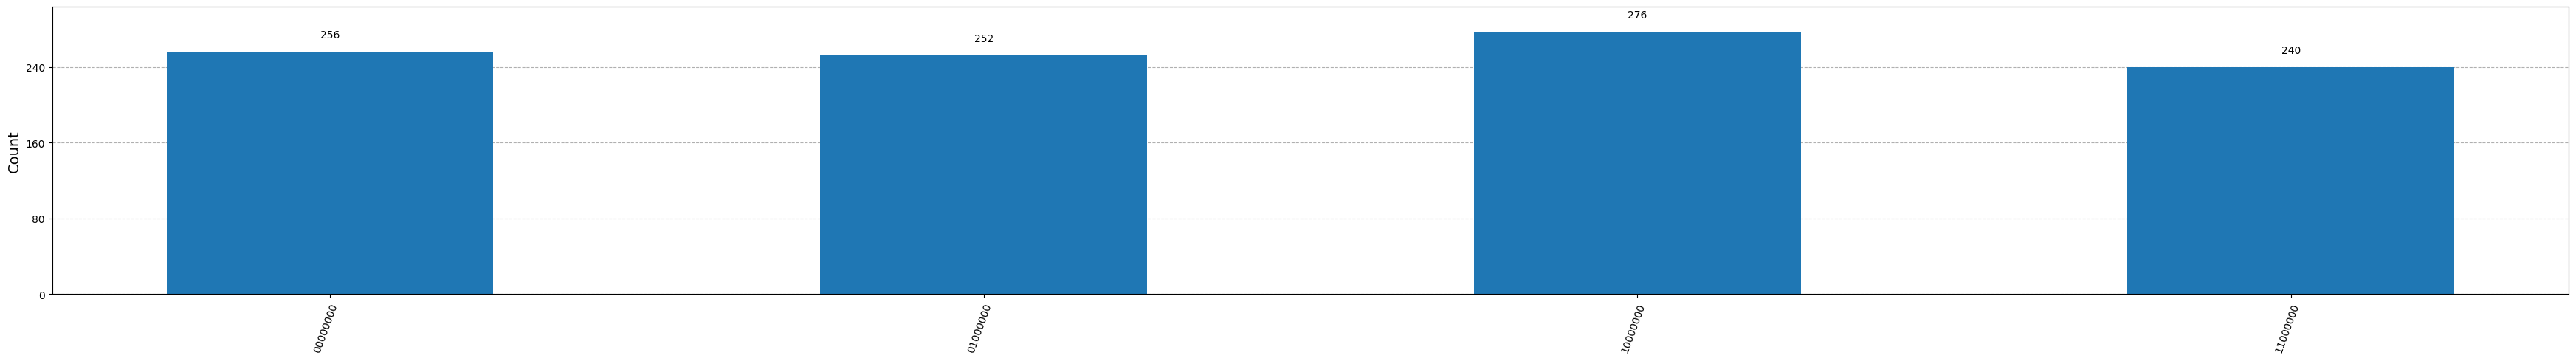

In [8]:
plot_histogram(counts, figsize=(35, 5))

In [9]:
# Dictionary of bitstrings and their counts to keep
counts_keep = {}
# Threshold to filter
threshold = np.max(list(counts.values())) / 2

for key, value in counts.items():
    if value > threshold:
        counts_keep[key] = value

print(counts_keep)

{'01000000': 252, '10000000': 276, '11000000': 240, '00000000': 256}


In [ ]:
a = 2
N = 15

FACTOR_FOUND = False
num_attempt = 0

while not FACTOR_FOUND:
    print(f"\nATTEMPT {num_attempt}:")
    # Here, we get the bitstring by iterating over outcomes
    # of a previous run with multiple shots.
    # Instead, we can also perform a single-shot measurement
    # here in the loop.
    bitstring = list(counts_keep.keys())[num_attempt]
    num_attempt += 1
    # Find the phase from measurement
    decimal = int(bitstring, 2)
    phase = decimal / (2**num_control)  # phase = k / r
    print(f"Phase: theta = {phase}")

    # Guess the order from phase
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator  # order = r
    print(f"Order of {a} modulo {N} estimated as: r = {r}")

    if phase != 0:
        # Guesses for factors are gcd(a^{r / 2} ± 1, 15)
        if r % 2 == 0:
            x = pow(a, r // 2, N) - 1
            p = gcd(x, N)
            if p > 1:
                FACTOR_FOUND = True
                print(f"*** Non-trivial factor found: {x} ***")
                q = N//p
                if p*q != 0:
                    print(f"Factors of N={N} are p={p} and q={q}")


ATTEMPT 0:
Phase: theta = 0.25
Order of 2 modulo 15 estimated as: r = 4
*** Non-trivial factor found: 3 ***
Factors of N=15 are p=3 and q=5
